# Modelo de Regresión Logística

## Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento y evaluación
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Configuración
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## Carga de datos

In [ ]:
df_train = pd.read_csv('train_processed.csv')
df_test = pd.read_csv('test.csv')

print(f"Datos cargados - Entrenamiento: {df_train.shape}, Prueba: {df_test.shape}")
display(df_train.head())

Datos cargados - Entrenamiento: (692500, 54), Prueba: (296786, 20)


,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_EDUCACIONPADRE,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4,ESTU_PRGM_ACADEMICO_ORIGINAL,prgm_administracion de empresas,prgm_administracion en salud ocupacional,prgm_administracion financiera,prgm_arquitectura,prgm_comunicacion social,prgm_contaduria publica,prgm_derecho,prgm_economia,prgm_enfermeria,prgm_ingenieria ambiental,prgm_ingenieria civil,prgm_ingenieria de sistemas,prgm_ingenieria electronica,prgm_ingenieria industrial,prgm_ingenieria mecanica,prgm_licenciatura en pedagogia infantil,prgm_medicina,prgm_negocios internacionales,prgm_otros,prgm_psicologia,prgm_trabajo social,FAMI_TIENEINTERNET_No,FAMI_TIENEINTERNET_Si,FAMI_TIENEINTERNET_no info,ESTU_PAGOMATRICULAPROPIO_No,ESTU_PAGOMATRICULAPROPIO_Si,ESTU_PAGOMATRICULAPROPIO_no info,FAMI_TIENELAVADORA_No,FAMI_TIENELAVADORA_Si,FAMI_TIENELAVADORA_no info,FAMI_TIENEAUTOMOVIL_No,FAMI_TIENEAUTOMOVIL_Si,FAMI_TIENEAUTOMOVIL_no info,ESTU_PRIVADO_LIBERTAD_N,ESTU_PRIVADO_LIBERTAD_S,FAMI_TIENECOMPUTADOR_No,FAMI_TIENECOMPUTADOR_Si,FAMI_TIENECOMPUTADOR_no info
0,904256,20212,enfermeria,BOGOTÁ,7.0,2.0,4.0,8.0,Si,12.0,3.0,0.322,0.208,0.310,0.267,enfermeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False
1,645256,20212,derecho,ATLANTICO,5.0,1.0,4.0,9.0,No,8.0,1.0,0.311,0.215,0.292,0.264,derecho,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False
2,308367,20203,otros,BOGOTÁ,5.0,5.0,4.0,7.0,Si,7.0,1.0,0.297,0.214,0.305,0.264,mercadeo y publicidad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,True,False,True,False,False,False,True,False,True,False,False,True,False,True,False,False
3,470353,20195,administracion de empresas,SANTANDER,6.0,1.0,5.0,2.0,Si,7.0,4.0,0.485,0.172,0.252,0.190,administracion de empresas,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False
4,989032,20212,psicologia,ANTIOQUIA,5.0,4.0,4.0,5.0,Si,5.0,2.0,0.316,0.232,0.285,0.294,psicologia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False


## Preparación de características

En esta etapa, nos enfocamos en la preparación de características, donde llevaremos a cabo un preprocesamiento exhaustivo que incluye la limpieza de datos, el manejo adecuado de valores faltantes y la selección de características relevantes para asegurar la calidad y pertinencia de los datos que alimentarán nuestro modelo

In [ ]:
columns_to_drop = ['ESTU_CONSECUTIVO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_ACADEMICO_ORIGINAL']
columns_to_drop = [col for col in columns_to_drop if col in df_train.columns]

X = df_train.drop(columns=columns_to_drop + ['RENDIMIENTO_GLOBAL'])
y = df_train['RENDIMIENTO_GLOBAL']

label_mapping = {0: 'no info', 1: 'bajo', 2: 'medio-bajo', 3: 'medio-alto', 4: 'alto'}

print(f"Características: {X.shape}, Variable objetivo: {y.shape}")
print(f"Distribución de clases:\n{y.value_counts().sort_index()}")

Características: (692500, 51), Variable objetivo: (692500,)
Distribución de clases:
RENDIMIENTO_GLOBAL
1.0    172987
2.0    172275
3.0    171619
4.0    175619
Name: count, dtype: int64


## Análisis y limpieza de datos

In [ ]:
# Análisis inicial de características
print("ANÁLISIS INICIAL DE CARACTERÍSTICAS")

# Seleccionar características numéricas
numeric_columns = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_columns]

print(f"Características totales: {X.shape[1]}")
print(f"Características numéricas: {X_numeric.shape[1]}")
print(f"Valores faltantes: {X_numeric.isnull().sum().sum()}")

# Eliminar características con varianza cero
zero_var_cols = X_numeric.columns[X_numeric.var() == 0]
if len(zero_var_cols) > 0:
    print(f"Eliminando {len(zero_var_cols)} características con varianza cero")
    X_numeric = X_numeric.drop(columns=zero_var_cols)

X = X_numeric.copy()
print(f"Características finales: {X.shape[1]}")

ANÁLISIS INICIAL DE CARACTERÍSTICAS
Características totales: 51
Características numéricas: 32
Valores faltantes: 0
Características finales: 32


## Análisis de distribución de clases

ANÁLISIS DE DISTRIBUCIÓN DE CLASES
Distribución de clases:
  bajo: 172,987 (25.0%)
  medio-bajo: 172,275 (24.9%)
  medio-alto: 171,619 (24.8%)
  alto: 175,619 (25.4%)
Ratio desbalance: 1.02


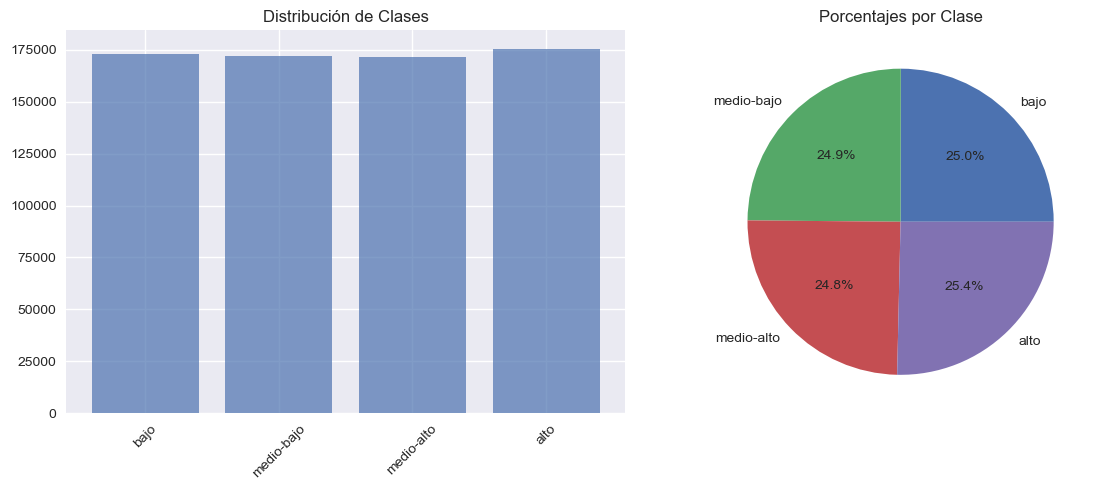

In [ ]:
# Análisis detallado de distribución de clases
print("ANÁLISIS DE DISTRIBUCIÓN DE CLASES")

class_distribution = y.value_counts().sort_index()
total_samples = len(y)

print("Distribución de clases:")
for class_idx, count in class_distribution.items():
    label = label_mapping[class_idx]
    percentage = (count / total_samples) * 100
    print(f"  {label}: {count:,} ({percentage:.1f}%)")

# Verificar desbalance
max_class_ratio = class_distribution.max() / class_distribution.min()
print(f"Ratio desbalance: {max_class_ratio:.2f}")

# Visualización
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
labels = [label_mapping[i] for i in class_distribution.index]
plt.bar(labels, class_distribution.values, alpha=0.7)
plt.title('Distribución de Clases')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(class_distribution.values, labels=labels, autopct='%1.1f%%')
plt.title('Porcentajes por Clase')
plt.tight_layout()
plt.show()

X_filtered = X.copy()

## División de datos y escalado

In [ ]:
# División de datos estratificada
print("Dividiendo datos de forma estratificada...")

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"División de datos:")
print(f"  Entrenamiento: {X_train.shape[0]:,} muestras")
print(f"  Validación: {X_val.shape[0]:,} muestras")
print(f"  Prueba: {X_test.shape[0]:,} muestras")

# Escalado StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Escalado completado")

Dividiendo datos de forma estratificada...
División de datos:
  Entrenamiento: 415,500 muestras
  Validación: 138,500 muestras
  Prueba: 138,500 muestras
Escalado completado


## Selección de características

Aplicamos selección de características univariada.

In [ ]:
# Selección de características univariada rápida para datasets grandes
print("Aplicando selección univariada de características...")

# Evaluar diferentes números de características a seleccionar
k_values = [10, 15, 20, 25, 30]
best_k = None
best_score = 0

# Modelo base para evaluación rápida
lr_eval = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')

for k in k_values:
    # Seleccionar k mejores características
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)

    # Evaluación rápida con validación cruzada
    cv_scores = cross_val_score(lr_eval, X_train_selected, y_train, cv=3, scoring='accuracy')
    mean_score = cv_scores.mean()

    print(f"k={k}: {mean_score:.4f} (±{cv_scores.std():.4f})")

    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Mejor k: {best_k} con accuracy: {best_score:.4f}")

# Aplicar selección final
feature_selector = SelectKBest(score_func=f_classif, k=best_k)
X_train_selected = feature_selector.fit_transform(X_train_scaled, y_train)
X_val_selected = feature_selector.transform(X_val_scaled)
X_test_selected = feature_selector.transform(X_test_scaled)

print(f"Características seleccionadas: {X_train_selected.shape[1]}")
print("Selección de características completada")

Aplicando selección univariada de características...
k=10: 0.3581 (±0.0005)
k=15: 0.3656 (±0.0008)
k=20: 0.3718 (±0.0011)
k=25: 0.3745 (±0.0014)
k=30: 0.3751 (±0.0012)
Mejor k: 30 con accuracy: 0.3751
Características seleccionadas: 30
Selección de características completada


## Optimización de Regresión Logística

Liblinear L1: 0.3754 (±0.0005)
Liblinear L2: 0.3754 (±0.0005)
SAG L2: 0.3757 (±0.0004)
SAGA L1: 0.3757 (±0.0005)
SAGA L2: 0.3757 (±0.0004)


,Configuración,Mean_Accuracy,Std_Accuracy
2,SAG L2,0.375728,0.000443
4,SAGA L2,0.375728,0.000438
3,SAGA L1,0.375718,0.000451
1,Liblinear L2,0.375384,0.000507
0,Liblinear L1,0.375353,0.000519


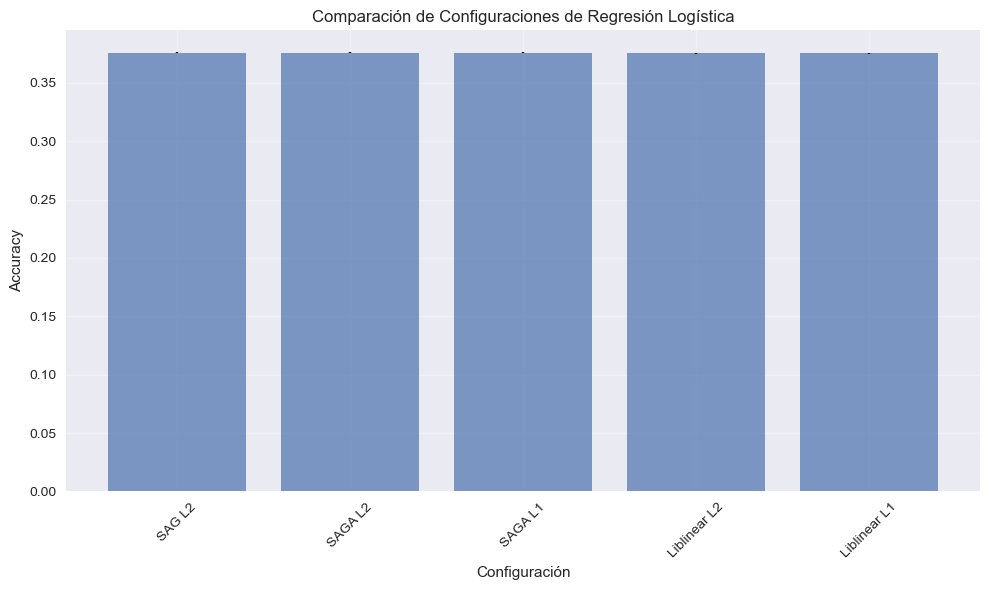

Mejor configuración: SAG L2


In [ ]:
lr_configs = {
    'Liblinear L1': LogisticRegression(solver='liblinear', penalty='l1', random_state=42, max_iter=1000),
    'Liblinear L2': LogisticRegression(solver='liblinear', penalty='l2', random_state=42, max_iter=1000),
    'SAG L2': LogisticRegression(solver='sag', penalty='l2', random_state=42, max_iter=1000),
    'SAGA L1': LogisticRegression(solver='saga', penalty='l1', random_state=42, max_iter=1000),
    'SAGA L2': LogisticRegression(solver='saga', penalty='l2', random_state=42, max_iter=1000)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
lr_results = {}

for name, model in lr_configs.items():
    try:
        cv_scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='accuracy')
        lr_results[name] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std()
        }
        print(f"{name}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    except Exception as e:
        print(f"{name}: Error - {str(e)}")

# Crear DataFrame y visualización
results_df = pd.DataFrame({
    'Configuración': list(lr_results.keys()),
    'Mean_Accuracy': [lr_results[name]['mean'] for name in lr_results.keys()],
    'Std_Accuracy': [lr_results[name]['std'] for name in lr_results.keys()]
}).sort_values('Mean_Accuracy', ascending=False)

display(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Configuración'], results_df['Mean_Accuracy'],
        yerr=results_df['Std_Accuracy'], capsize=5, alpha=0.7)
plt.title('Comparación de Configuraciones de Regresión Logística')
plt.xlabel('Configuración')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_config_name = results_df.iloc[0]['Configuración']
best_lr_model = lr_configs[best_config_name]
print(f"Mejor configuración: {best_config_name}")

## Entrenamiento y evaluación

Entrenamos la mejor configuración de Regresión Logística.

Accuracy en validación: 0.3756
Log-loss en validación: 1.2921

Reporte de clasificación:
              precision    recall  f1-score   support

        bajo       0.38      0.52      0.44     34597
  medio-bajo       0.32      0.22      0.26     34455
  medio-alto       0.29      0.17      0.21     34324
        alto       0.43      0.60      0.50     35124

    accuracy                           0.38    138500
   macro avg       0.36      0.37      0.35    138500
weighted avg       0.36      0.38      0.35    138500



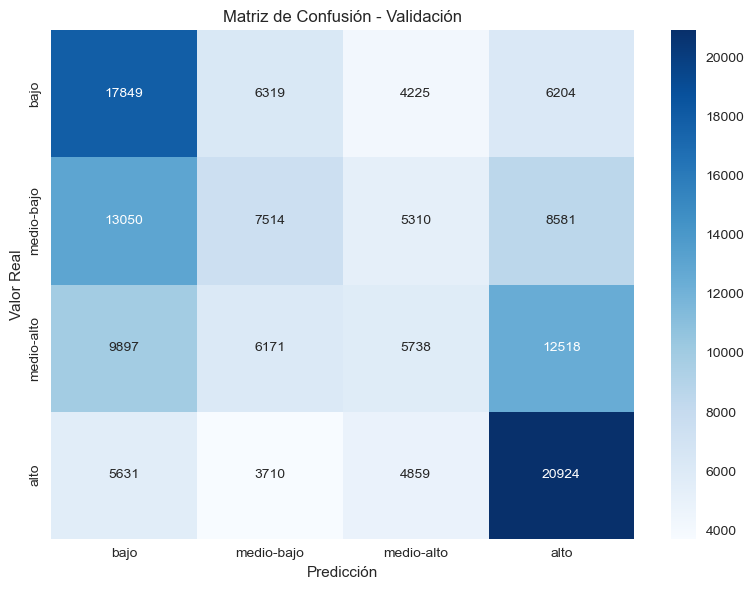

Top 10 características más importantes:


,Feature,Importance
5,FAMI_EDUCACIONMADRE,0.136799
11,prgm_administracion en salud ocupacional,0.114810
24,prgm_licenciatura en pedagogia infantil,0.110490
10,prgm_administracion de empresas,0.103621
7,coef_2,0.102315
15,prgm_contaduria publica,0.083360
2,ESTU_HORASSEMANATRABAJA,0.078628
28,prgm_psicologia,0.074404
3,FAMI_ESTRATOVIVIENDA,0.064696
0,PERIODO,0.060908


In [ ]:
# Entrenar la mejor configuración de Regresión Logística
final_lr_model = lr_configs[best_config_name]
final_lr_model.fit(X_train_selected, y_train)

# Predicciones en validación
y_val_pred = final_lr_model.predict(X_val_selected)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_val_proba = final_lr_model.predict_proba(X_val_selected)
val_log_loss = log_loss(y_val, y_val_proba)

print(f"Accuracy en validación: {val_accuracy:.4f}")
print(f"Log-loss en validación: {val_log_loss:.4f}")

# Reporte de clasificación
label_mapping = {0: 'no info', 1: 'bajo', 2: 'medio-bajo', 3: 'medio-alto', 4: 'alto'}
target_names = [label_mapping[i] for i in sorted(label_mapping.keys()) if i in y_val.unique()]
print("\nReporte de clasificación:")
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

# Características más importantes
feature_names = X_filtered.columns[feature_selector.get_support()]
if hasattr(final_lr_model, 'coef_'):
    importance = np.abs(final_lr_model.coef_).mean(axis=0)
    top_features = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(10)

    print("Top 10 características más importantes:")
    display(top_features)

## Evaluación en conjunto de prueba

Accuracy en prueba: 0.3748
Log-loss en prueba: 1.2935

Reporte de clasificación:
              precision    recall  f1-score   support

        bajo       0.39      0.52      0.44     34597
  medio-bajo       0.31      0.22      0.26     34455
  medio-alto       0.29      0.17      0.21     34324
        alto       0.43      0.59      0.50     35124

    accuracy                           0.37    138500
   macro avg       0.35      0.37      0.35    138500
weighted avg       0.35      0.37      0.35    138500


Resumen de rendimiento:
  Validación cruzada: 0.3757 (±0.0004)
  Conjunto validación: 0.3756
  Conjunto prueba: 0.3748
Buena generalización (diferencia: 0.001)


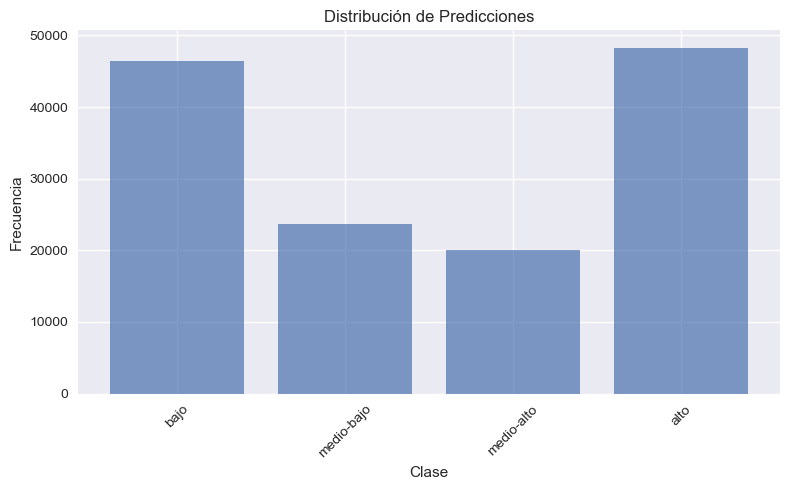

Distribución de predicciones:
  bajo: 46,435 (33.5%)
  medio-bajo: 23,676 (17.1%)
  medio-alto: 20,086 (14.5%)
  alto: 48,303 (34.9%)


In [ ]:
y_test_pred = final_lr_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)

y_test_proba = final_lr_model.predict_proba(X_test_selected)
test_log_loss = log_loss(y_test, y_test_proba)

print(f"Accuracy en prueba: {test_accuracy:.4f}")
print(f"Log-loss en prueba: {test_log_loss:.4f}")

target_names_test = [label_mapping[i] for i in sorted(label_mapping.keys()) if i in y_test.unique()]
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred, target_names=target_names_test))

# Resumen de rendimiento
print(f"\nResumen de rendimiento:")
print(f"  Validación cruzada: {lr_results[best_config_name]['mean']:.4f} (±{lr_results[best_config_name]['std']:.4f})")
print(f"  Conjunto validación: {val_accuracy:.4f}")
print(f"  Conjunto prueba: {test_accuracy:.4f}")

# Verificar generalización
accuracy_diff = abs(val_accuracy - test_accuracy)
if accuracy_diff > 0.02:
    print(f"Posible sobreajuste (diferencia: {accuracy_diff:.3f})")
else:
    print(f"Buena generalización (diferencia: {accuracy_diff:.3f})")

# Distribución de predicciones
pred_distribution = pd.Series(y_test_pred).value_counts().sort_index()
pred_labels = [label_mapping[i] for i in pred_distribution.index]

plt.figure(figsize=(8, 5))
plt.bar(pred_labels, pred_distribution.values, alpha=0.7)
plt.title('Distribución de Predicciones')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Distribución de predicciones:")
for i, count in pred_distribution.items():
    print(f"  {label_mapping[i]}: {count:,} ({count/len(y_test_pred)*100:.1f}%)")

## Entrenamiento del modelo

In [ ]:
# Entrenar modelo final con todos los datos disponibles
print(f"Entrenando modelo final con todos los datos...")

# Preparar todos los datos con el mismo preprocesamiento
X_all_scaled = scaler.fit_transform(X_filtered)
X_all_selected = feature_selector.fit_transform(X_all_scaled, y)

# Crear modelo final con la mejor configuración
final_model_all_data = LogisticRegression(
    solver=final_lr_model.solver,
    penalty=final_lr_model.penalty,
    random_state=42,
    max_iter=1000
)

# Entrenar con todos los datos
final_model_all_data.fit(X_all_selected, y)

train_accuracy_full = final_model_all_data.score(X_all_selected, y)

print(f"Modelo final entrenado: {best_config_name}")
print(f"Datos de entrenamiento: {len(X_filtered):,} muestras")
print(f"Características seleccionadas: {X_all_selected.shape[1]}")
print(f"Accuracy en datos completos: {train_accuracy_full:.4f}")

Entrenando modelo final con todos los datos...
Modelo final entrenado: SAG L2
Datos de entrenamiento: 692,500 muestras
Características seleccionadas: 30
Accuracy en datos completos: 0.3757


## Predicciones en datos de prueba

In [ ]:
test_columns_to_drop = ['ESTU_CONSECUTIVO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_ACADEMICO_ORIGINAL']
test_columns_to_drop = [col for col in test_columns_to_drop if col in df_test.columns]

if test_columns_to_drop:
    print(f"Removiendo columnas de identificación: {test_columns_to_drop}")

# Obtener características numéricas de test igual que en entrenamiento
df_test_clean = df_test.drop(columns=test_columns_to_drop)
test_numeric_columns = df_test_clean.select_dtypes(include=[np.number]).columns
X_test_numeric = df_test_clean[test_numeric_columns]

print(f"Características numéricas en test: {X_test_numeric.shape[1]}")
print(f"Características esperadas del entrenamiento: {X_filtered.shape[1]}")

train_features = set(X_filtered.columns)
test_features = set(X_test_numeric.columns)

common_features = train_features & test_features
missing_features = train_features - test_features
extra_features = test_features - train_features

print(f"\nDIAGNÓSTICO DE CARACTERÍSTICAS:")
print(f"  - Comunes: {len(common_features)}")
print(f"  - Faltantes en test: {len(missing_features)}")
print(f"  - Extra en test: {len(extra_features)}")

if missing_features:
    print(f"  Características faltantes (primeras 10):")
    for i, feature in enumerate(sorted(missing_features)[:10]):
        print(f"    {i+1:2d}. {feature}")
    if len(missing_features) > 10:
        print(f"    ... y {len(missing_features) - 10} más")

if extra_features:
    print(f"  Características extra en test (primeras 10):")
    for i, feature in enumerate(sorted(extra_features)[:10]):
        print(f"    {i+1:2d}. {feature}")
    if len(extra_features) > 10:
        print(f"    ... y {len(extra_features) - 10} más")

X_test_aligned = pd.DataFrame(index=df_test.index)

train_stats = {}
for feature in X_filtered.columns:
    stats = {
        'mean': X_filtered[feature].mean(),
        'median': X_filtered[feature].median(),
        'std': X_filtered[feature].std(),
        'min': X_filtered[feature].min(),
        'max': X_filtered[feature].max(),
        'nunique': X_filtered[feature].nunique(),
        'is_binary': X_filtered[feature].nunique() <= 2,
        'q25': X_filtered[feature].quantile(0.25),
        'q75': X_filtered[feature].quantile(0.75)
    }
    train_stats[feature] = stats


features_added = 0
features_imputed = 0

for feature in X_filtered.columns:
    if feature in X_test_numeric.columns:
        X_test_aligned[feature] = X_test_numeric[feature].copy()
        features_added += 1
    else:
        stats = train_stats[feature]

        if stats['is_binary']:
            mode_value = X_filtered[feature].mode().iloc[0] if not X_filtered[feature].mode().empty else 0
            impute_value = mode_value
        elif stats['std'] < 0.01:
            impute_value = stats['mean']
        else:
            impute_value = stats['median']

        X_test_aligned[feature] = impute_value
        features_imputed += 1

print(f"Características procesadas:")
print(f"  - Copiadas: {features_added}")
print(f"  - Imputadas: {features_imputed}")
print(f"  - Total: {X_test_aligned.shape[1]}")

X_test_aligned = X_test_aligned[X_filtered.columns]

type_corrections = 0
for col in X_filtered.columns:
    train_dtype = X_filtered[col].dtype
    test_dtype = X_test_aligned[col].dtype

    if train_dtype != test_dtype:
        try:
            X_test_aligned[col] = X_test_aligned[col].astype(train_dtype)
            type_corrections += 1
        except Exception as e:
            print(f"  Error convirtiendo {col}: {e}")

if type_corrections > 0:
    print(f"Tipos corregidos: {type_corrections}")
else:
    print("Todos los tipos de datos coinciden")

null_count = X_test_aligned.isnull().sum().sum()
inf_count = np.isinf(X_test_aligned.select_dtypes(include=[np.number]).values).sum()

print(f"Valores nulos: {null_count}")
print(f"Valores infinitos: {inf_count}")

if null_count > 0:

    for col in X_test_aligned.columns:
        if X_test_aligned[col].isnull().any():
            fill_value = train_stats[col]['median'] if not train_stats[col]['is_binary'] else 0
            X_test_aligned[col] = X_test_aligned[col].fillna(fill_value)

if inf_count > 0:

    numeric_cols = X_test_aligned.select_dtypes(include=[np.number]).columns
    X_test_aligned[numeric_cols] = X_test_aligned[numeric_cols].replace([np.inf, -np.inf], np.nan)
    for col in numeric_cols:
        if X_test_aligned[col].isnull().any():
            X_test_aligned[col] = X_test_aligned[col].fillna(train_stats[col]['median'])


outlier_corrections = 0
for col in X_filtered.columns:
    train_min, train_max = train_stats[col]['min'], train_stats[col]['max']
    test_values = X_test_aligned[col]

    # Detectar outliers extremos
    train_range = train_max - train_min
    if train_range > 0:
        lower_bound = train_min - 3 * train_stats[col]['std']
        upper_bound = train_max + 3 * train_stats[col]['std']

        outliers_mask = (test_values < lower_bound) | (test_values > upper_bound)
        outlier_count = outliers_mask.sum()

        if outlier_count > 0:
            # Recortar outliers extremos a los percentiles de entrenamiento
            X_test_aligned.loc[outliers_mask & (test_values < lower_bound), col] = train_stats[col]['q25']
            X_test_aligned.loc[outliers_mask & (test_values > upper_bound), col] = train_stats[col]['q75']
            outlier_corrections += outlier_count

X_test_scaled = scaler.transform(X_test_aligned)

X_test_selected = feature_selector.transform(X_test_scaled)

print(f"Datos procesados finales: {X_test_selected.shape}")

# Verificar distribución de características seleccionadas
selected_features_mean = X_test_selected.mean(axis=0)
selected_features_std = X_test_selected.std(axis=0)


test_predictions = final_model_all_data.predict(X_test_selected)
test_probabilities = final_model_all_data.predict_proba(X_test_selected)

unique_predictions = np.unique(test_predictions)
print(f"  - Clases predichas únicas: {len(unique_predictions)} de 5 posibles")
print(f"  - Clases predichas: {unique_predictions}")

# Estadísticas de probabilidades por clase
for i, class_label in enumerate(['no info', 'bajo', 'medio-bajo', 'medio-alto', 'alto']):
    if i < test_probabilities.shape[1]:
        class_probs = test_probabilities[:, i]
        print(f"  - {class_label}: min={class_probs.min():.4f}, max={class_probs.max():.4f}, mean={class_probs.mean():.4f}")

# Convertir a etiquetas para submission
label_mapping = {0: 'no info', 1: 'bajo', 2: 'medio-bajo', 3: 'medio-alto', 4: 'alto'}
prediction_labels = [label_mapping[pred] for pred in test_predictions]

print(f"\nPredicciones generadas: {len(test_predictions):,}")

# Distribución final de predicciones
pred_counts = pd.Series(prediction_labels).value_counts()
print(f"\nDISTRIBUCIÓN FINAL DE PREDICCIONES:")
for label, count in pred_counts.items():
    percentage = (count / len(prediction_labels)) * 100
    print(f"  - {label}: {count:,} ({percentage:.1f}%)")

Removiendo columnas de identificación: ['ESTU_PRGM_ACADEMICO']
Características numéricas en test: 6
Características esperadas del entrenamiento: 32

DIAGNÓSTICO DE CARACTERÍSTICAS:
  - Comunes: 6
  - Faltantes en test: 26
  - Extra en test: 0
  Características faltantes (primeras 10):
     1. ESTU_HORASSEMANATRABAJA
     2. ESTU_VALORMATRICULAUNIVERSIDAD
     3. FAMI_EDUCACIONMADRE
     4. FAMI_EDUCACIONPADRE
     5. FAMI_ESTRATOVIVIENDA
     6. prgm_administracion de empresas
     7. prgm_administracion en salud ocupacional
     8. prgm_administracion financiera
     9. prgm_arquitectura
    10. prgm_comunicacion social
    ... y 16 más
Características procesadas:
  - Copiadas: 6
  - Imputadas: 26
  - Total: 32
Todos los tipos de datos coinciden
Valores nulos: 0
Valores infinitos: 0
Datos procesados finales: (296786, 30)
  - Clases predichas únicas: 4 de 5 posibles
  - Clases predichas: [1. 2. 3. 4.]
  - no info: min=0.1010, max=0.3824, mean=0.2156
  - bajo: min=0.1489, max=0.3074, me

## Archivo de submission

In [ ]:
# Crear archivo de submission
if 'ID' in df_test.columns:
    submission_df = pd.DataFrame({
        'ID': df_test['ID'],
        'RENDIMIENTO_GLOBAL': prediction_labels
    })
elif 'ESTU_CONSECUTIVO' in df_test.columns:
    submission_df = pd.DataFrame({
        'ID': df_test['ESTU_CONSECUTIVO'],
        'RENDIMIENTO_GLOBAL': prediction_labels
    })
else:
    submission_df = pd.DataFrame({
        'ID': range(len(prediction_labels)),
        'RENDIMIENTO_GLOBAL': prediction_labels
    })

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Archivo guardado: {submission_filename}")
print(f"Registros: {len(submission_df):,}")

display(submission_df.head(10))

# Verificaciones
null_count = submission_df.isnull().sum().sum()
unique_predictions = submission_df['RENDIMIENTO_GLOBAL'].unique()

print(f"Valores nulos: {null_count}")
print(f"Clases en predicciones: {sorted(unique_predictions)}")
print(f"Modelo: {best_config_name}")
print(f"Pipeline: StandardScaler + SelectKBest({best_k}) + LogisticRegression")

Archivo guardado: submission.csv
Registros: 296,786


,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-alto
2,499179,medio-alto
3,782980,medio-bajo
4,785185,medio-alto
5,58495,medio-bajo
6,705444,alto
7,557548,alto
8,519909,medio-alto
9,832058,medio-alto


Valores nulos: 0
Clases en predicciones: ['alto', 'bajo', 'medio-alto', 'medio-bajo']
Modelo: SAG L2
Pipeline: StandardScaler + SelectKBest(30) + LogisticRegression


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [ ]:
import shutil

In [ ]:
!kaggle competitions submit -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia -f submission.csv -m "Preprocesado 3"

Successfully submitted to UDEA/ai4eng 20251 - Pruebas Saber Pro Colombia



  0%|          | 0.00/4.66M [00:00<?, ?B/s]
  0%|          | 8.00k/4.66M [00:00<03:32, 22.9kB/s]
  6%|5         | 280k/4.66M [00:00<00:05, 810kB/s]  
  9%|9         | 440k/4.66M [00:00<00:04, 966kB/s]
 12%|#2        | 584k/4.66M [00:01<00:07, 545kB/s]
 17%|#6        | 792k/4.66M [00:01<00:05, 791kB/s]
 21%|##1       | 1.00M/4.66M [00:01<00:03, 1.06MB/s]
 25%|##4       | 1.16M/4.66M [00:01<00:05, 691kB/s] 
 28%|##7       | 1.29M/4.66M [00:01<00:04, 777kB/s]
 30%|###       | 1.41M/4.66M [00:02<00:06, 511kB/s]
 33%|###2      | 1.52M/4.66M [00:02<00:05, 582kB/s]
 35%|###5      | 1.65M/4.66M [00:02<00:04, 694kB/s]
 39%|###8      | 1.80M/4.66M [00:02<00:03, 838kB/s]
 42%|####2     | 1.96M/4.66M [00:02<00:02, 982kB/s]
 46%|####6     | 2.16M/4.66M [00:02<00:02, 1.18MB/s]
 51%|#####     | 2.36M/4.66M [00:02<00:01, 1.40MB/s]
 55%|#####5    | 2.57M/4.66M [00:03<00:01, 1.55MB/s]
 61%|######    | 2.82M/4.66M [00:03<00:01, 1.81MB/s]
 65%|######5   | 3.04M/4.66M [00:03<00:00, 1.90MB/s]
 69%|######9 

In [ ]:
!kaggle competitions submissions -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

fileName           date                        description                                            status                     publicScore  privateScore  
-----------------  --------------------------  -----------------------------------------------------  -------------------------  -----------  ------------  
submission.csv     2025-07-04 00:02:57.940000  Preprocesado 3                                         SubmissionStatus.COMPLETE  0.30879                    
submission.csv     2025-07-03 23:55:29.800000  05 modelo con feature engineering y Gradient Boosting  SubmissionStatus.COMPLETE  0.25804                    
submission.csv     2025-07-03 21:57:23.173000  05 modelo con feature engineering y Gradient Boosting  SubmissionStatus.COMPLETE  0.27041                    
submission.csv     2025-07-03 18:38:55.810000  Preprocesado 1                                         SubmissionStatus.COMPLETE  0.40097                    
submission_rf.csv  2025-07-03 18:17:28.673000  Preprocesad